## Benvenuto, iniziamo!

Questo è un **Notebook in Python**, cioè uno strumento interattivo per scrivere ed eseguire del codice in modo dinamico. È composto da *celle* che possono contenere testo (come questa) oppure codice Python (come la prossima).

Per *eseguire* i comandi in una cella, puoi:
- cliccare sul simbolo "Play" a sinistra della cella, oppure
- selezionare la cella e premere Shift + Invio sulla tastiera

Se non è già stato selezionato, al primo avvio Visual Studio potrebbe chiederti con quale *kernel* eseguire il codice (in pratica... con quale "versione" di Python): tu seleziona *Python Environments* e poi *env*. Abbiamo configurato noi l'ambiente così da farti trovare tutte le librerie necessarie già pronte per l'uso!

Perché tutto funzioni come previsto, ricordati di eseguire ogni cella di codice prima di passare alla successiva. Le variabili, funzioni e classi definite in una cella sono utilizzabili in tutto il notebook, una volta che la cella viene eseguita.

Per il resto, è il solito Python. Buon lavoro! 🚀

In [ ]:
# Importiamo le librerie necessarie
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch # questa è una libreria molto usata per le Reti Neurali
import torchvision

## Il problema: riconoscimento immagini
Il tuo obiettivo sarà seguire passo dopo passo (e personalizzare) la costruzione e l'addestramento di una rete neurale per classificare un certo tipo di immagini. Queste immagini saranno di dimensione 28x28 pixel e rappresenteranno **numeri da 0 a 9 scritti a mano** (quindi con grafie diverse tra loro). Noi umani siamo ben in grado di riconoscere scritture differenti... Vorremmo che la rete neurale fosse in grado di fare la stessa cosa!

Ingredienti:
- i dati (immagini dei numeri)
- il modello (rete neurale)
- l'allenamento (processo con cui la rete impara a riconoscere i numeri)

### 1) I dati
La libreria PyTorch offre la possibilità di scaricare i dataset più usati con grande facilità.

Ci servono:
- un insieme di dati per allenare il modello (*train set*) 
- un insieme di dati (diversi) per testarlo (*test set*).

Secondo te, come mai è importante testare il modello su esempi diversi da quelli su cui è allenato?

In [ ]:
# Applichiamo la trasformazione ToTensor() per convertire le immagini in tensori (sono una specie di vettori)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Importiamo e scarichiamo i dati di train e di test
train_set = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Creiamo un dataloader per il train e uno per il test
# questo tipo di oggetto permette in modo efficiente di gestire e caricare i dati in PyTorch...
# dal nostro punto di vista è importante solo sapere che questi oggetti contengono i dati che useremo nel nostro modello!
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)


Una volta scaricati i dati, possiamo visualizzarne alcuni per capire come sono fatti! Prendiamo 5 esempi dal train set e stampiamoli a video con la libreria *matplotlib*.

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    # Visualizziamo cosa c'è nel train set... 
    # train_set è una lista di coppie
    # train_set[i][0] è l'immagine, mentre train_set[i][1] è il numero rappresentato nell'immagine (che chiamiamo "label")

    image, label = train_set[i]  # Otteniamo l'immagine e il label

    # Ci serve fare questo passaggio per convertire l'immagine in un oggetto visualizzabile con matplotlib (importata come plt)
    imago_to_plot = image.numpy().squeeze()

    ax[i].imshow(imago_to_plot, cmap='gray')
    ax[i].axis('off')

print('I numeri sono:', [train_set[i][1] for i in range(5)])

plt.show()


### 2) Il modello
Il modello che useremo sarà una rete neurale molto di base. Ripassiamo brevemente come sono fatte.
Le reti sono composte da neuroni, disposti in strati (*layers*), ognuno dei quali può contenere un numero variabile di neuroni. Il numero di strati è detto profondità (*depth*) della rete.

Nel modello che vedremo oggi, ogni neurone di un layer manda un segnale ad ogni neurone del layer successivo. La forza della connessione tra due neuroni è determinata da un peso ed è proprio questo peso quello che viene allenato. Quindi la rete, grazie all'allenamento, riuscirà a capire quale sia il peso migliore da usare in ogni connessione affinchè le immagini siano riconosciute correttamente!

Quello che succede in ciasun neurone è questo:
- riceve un'informazione da tutti i neuroni del layer precedente
- pesa i singoli input e li combina tra loro (facendo una **somma pesata**, ovvero una somma in cui ogni addendo è moltiplicato per un fattore, il peso)
- applica una cosidetta **funzione di attivazione** alla somma ottenuta
- manda il valore che ne risulta ad ogni neurone del layer successivo

Alla fine della rete, ci sarà un layer con un numero di neuroni pari al numero di classi in cui vogliamo classificare i nostri dati. Nel nostro caso saranno 10, perché stiamo cercando di riconoscere le cifre da 0 a 9.

#### Definiamo la rete neurale in Python
Per costruire una rete neurale ci serve usare la classe *SimpleNeuralNetwork*. Una classe in Python è un tipo di struttura che ti permette di creare nuovi oggetti con caratteristiche e comportamenti specifici (ad esempio, le liste di Python hanno la loro struttura e loro metodi, come *.append()*).

In [ ]:
# La rete neurale sarà un oggetto della classe SimpleNeuralNetwork, che definiamo noi
class SimpleNeuralNetwork(torch.nn.Module):

    # Definiamo la funzione per inizializzare una rete, ci serve sapere:
    # - depth, il numero di strati (layer) della rete
    # - width, il numero di neuroni in ogni singolo strato

    def __init__(self, depth, width):
        super().__init__() # questa riga fa "ereditare" automaticamente alla nostra classe alcune funzioni standard delle reti neurali
        self.layers = [] # creiamo la lista degli strati della rete, intanto vuota
        if depth <= 1:
            raise ValueError('depth deve essere almeno 1')
        
        # La lista layer avrà due elementi per ogni strato:
        # - un oggetto linear (per fare la somma pesata)
        # - un oggetto relu (la funzione di attivazione)
        self.layers.append(torch.nn.Linear(28*28, width)) # questo è il layer iniziale
                                                          # i primi neuroni riceveranno le immagini di 28x28 pixel del train set
        self.layers.append(torch.nn.ReLU())

        # Gli strati in mezzo sono tutti uguali (gli unici diversi sono il primo e l'ultimo)
        # quindi li definiamo con un ciclo for
        for i in range(depth-2):
            self.layers.append(torch.nn.Linear(width, width))
            self.layers.append(torch.nn.ReLU())
        
        # L'ultimo strato deve essere di 10 classi
        self.head = torch.nn.Linear(width, 10)
    
    # Definiamo la funzione che dice come far passare i valori tra un layer e l'altro
    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers:
            x = layer(x)
        x = self.head(x)
        return x

In [ ]:
# Cambia a piacere questi valori, basta che siano interi positivi (e che la depth sia almeno 2)
depth = 3
width = 32
model = SimpleNeuralNetwork(depth, width)

### 3) La strategia di allenamento

In modo simile (più o meno) a come le connessioni tra i nostri neuroni cambiano nel tempo per farci diventare più bravi nelle attività che facciamo, vogliamo cambiare i pesi tra le coppie di neuroni, che inizialmente sono casuali, in modo che la rete diventi brava a svolgere il compito che le assegniamo: cioè classificare le immagini capendo che numero c'è disegnato.

Per farlo, ci serve calcolare quanti errori di etichettamento fa la rete, dato un certo set di pesi. Definiamo, quindi, una funzione che chiamiamo *loss function* (o *cost function*), che tiene conto di quanto spesso la rete sbaglia a classificare le immagini del dataset. Se sbaglia molto spesso, la loss function sarà alta. Man mano che alleniamo la rete e questa inizia a classificare correttamente più immagini, vedremo che la loss function diventerà sempre più bassa.

Il nostro "allenamento" si propone proprio di cambiare i pesi della rete in modo da abbassare sempre di più il valore della loss function, e quindi di classificare correttamente sempre più immagini.

Calcoliamo la loss function prima di iniziare l'allenamento.

In [ ]:
# Prendiamo la funzione già definita
loss_function = torch.nn.CrossEntropyLoss()

# "Carichiamo" i dati
x, y = next(iter(test_loader))  
# Facciamo passare le immagini dentro al modello; y_pred contiene le predizioni per ogni immagine
y_pred = model(x)  

# Calcoliamo la loss confrontando le classificazioni corrette, già presenti nei dati, che abbiamo salvato nella variabile y, 
# con le classificazioni predette dal modello con i pesi attuali, salvate in y_pred
loss = loss_function(y_pred, y)

print('Loss prima dell\'allenamento:', loss.item())

Proviamo a visualizzare degli esempi per capire se il nostro modello è già buono o meno. Vediamo degli esempi di immagini e del numero in cui viene classificata ciascuna dal modello.

In [ ]:
# Visualizziamo alcuni esempi di immagini
# Creiamo una lista per memorizzare i labels
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

# Loop su una griglia 5x5
for j in range(5):
    for i in range(5):
        image, label = test_set[5*j + i]
        ax[j][i].imshow(image.numpy().squeeze(), cmap='gray')  # Convertiamo il tensore in NumPy
        ax[j][i].axis('off')

for j in range(5):
    for i in range(5):
        ax[j][i].set_title(str(torch.argmax(y_pred[5*j + i]).item()), fontsize=10, color='blue')

# Mostriamo la figura
plt.show()


Il modello *dà i numeri* (pun intended), ma sono sbagliati. Questo è perché non è ancora stato allenato, ovvero le connessioni tra coppie di neuroni sono dei numeri casuali. Ora vedremo come migliorarle.

La strategia più usata consiste nel calcolare la direzione in cui la loss function "scende" e fare un passetto in quella, usando alcuni dati; dopodiché, la si ricalcola, si ricalcola la direzione giusta e si fa un altro passetto, e così via. Questo algoritmo si chiama *Stochastic* (ovvero, si prendono pochi punti a caso su cui calcolare la funzione e la direzione in cui si scende) *Gradient* (è una generalizzazione della derivata, che dovreste vedere l'anno prossimo) *Descent* (si punta a minimizzare la Loss Function), di solito abbreviato *SGD*.

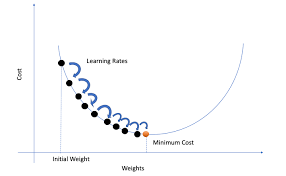

In [ ]:
# Prendiamo l'algoritmo dalla solita libreria; il parametro lr è il learning rate, ovvero l'ampiezza del passo
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

Adesso proviamo a fare uno di questi passi.

In [ ]:
# Prendiamo i pesi dell'ultimo layer prima del passo
weights_before = model.head.weight.clone()

# Ci serve fare un ciclo sul "caricatore" di dati, che automaticamente ne prende un po' scelti a caso
for images, labels in train_loader:   
    optimizer.zero_grad()  # Questo bisogna metterlo, prendetelo come una specie di reset
    outputs = model(images)  # Mettiamo le immagini dentro al modello e ci prendiamo le predizioni
    loss = loss_function(outputs, labels)  # Calcoliamo la loss function
    loss.backward()  # Questo comando calcola la direzione del passo da fare per ogni coppia di neuroni connessi della rete
    optimizer.step()  # La forza della connessione dei neuroni viene aggiornata
    break

# Prendiamo i pesi dell'ultimo layer dopo il passo
weights_after = model.head.weight.clone()

# Stampiamo i pesi della connessione tra il primo neurone del penultimo layer e i neuroni dell'ultimo layer
# Dovremmo vederli cambiare, anche se di poco, visto che abbiamo fatto un solo passetto
print(weights_before[0])
print(weights_after[0])

## Finalmente, possiamo allenare la rete neurale
Ora abbiamo tutti gli ingredienti per allenare la rete neurale.

La procedura di allenamento consiste semplicemente nel ripetere tante volte il passetto di prima. In particolare, se non si rompe il loop (usando break come alla cella prima), quando usiamo 

for images, labels in train_loader:  

facciamo un giro su tutto il train set; uno di questi giri si chiama *epoca*. Se non siamo soddisfatti del livello raggiunto dopo un'epoca, possiamo fare altri giri (ma ovviamente questo richiede più tempo!)

Nella cella qui sotto, riempi lo spazio per il singolo passetto come fatto sopra. Inoltre, per capire quanto bene la rete sta facendo, sarebbe comodo definire una funzione che calcoli l'*accuracy* (il numero di immagini che riesce a classificare correttamente, diviso per il totale delle immagini). Trovi la funzione sotto da completare come extra.

In [ ]:
# Training loop
num_epochs = 20  # Numero di epoche
test_losses = []

print("Starting Training...")

for epoch in range(num_epochs):
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = loss_function(outputs, labels)  
        loss.backward()  
        optimizer.step()  
        
    # Test the model
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss = loss_function(outputs, labels)
            #accuracy = calculate_accuracy(outputs, labels)
            test_losses.append(test_loss.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {test_loss:.4f}")
    #print(f"Accuracy: {accuracy:.4f}")

print("Training Completed!")


Come prima, visualizziamo alcune immagini insieme al numero che ci dà la rete. Magari non saranno tutti giusti, ma dovresti osservare un grande miglioramento rispetto a prima!

In generale, avere una rete più grande (ovvero con più neuroni per layer e con più layer) e allenarla di più dovrebbe aiutare.
Puoi provare a tornare alla cella in cui abbiamo definito il numero di neuroni e aumentarlo, oppure aumentare il numero di epoche, se non ti soddisfa il risultato raggiunto

In [ ]:

fig, ax = plt.subplots(5, 5, figsize=(10, 10))

# Loop su una griglia 5x5
for j in range(5):
    for i in range(5):
        image, label = test_set[5*j + i]
        outputs = model(image)
        ax[j][i].imshow(image.numpy().squeeze(), cmap='gray')  # Convertiamo il tensore in NumPy
        ax[j][i].axis('off')
        ax[j][i].set_title(str(torch.argmax(y_pred[5*j + i]).item()), fontsize=10, color='blue')

'''for j in range(5):
    for i in range(5):
        ax[j][i].set_title(str(torch.argmax(y_pred[5*j + i]).item()), fontsize=10, color='blue')'''

# Mostriamo la figura
plt.show()


## Extra: calcoliamo l'accuratezza della rete

Se sei arrivato fin qua

In [ ]:
def calculate_accuracy(outputs, labels):
    # Outputs è una matrice (=una tabella) con le probabilità di appartenenza ad ogni classe; è di dimensione (numero di immagini, numero di classi)
    # Per ottenere la classe predetta, prendiamo l'indice della colonna con probabilità massima
    predictions = torch.argmax(outputs, dim=1)
    # Ora predictions contiene il massimo di ogni riga, ovvero la classe predetta per ogni immagine

    # Scrivi qui il codice per calcolare l'accuracy
    # correct = ...
    # total = ...
    # return correct / total

def calculate_accuracy(outputs, labels):
    # Outputs è una matrice (=una tabella) con le probabilità di appartenenza ad ogni classe; è di dimensione (numero di immagini, numero di classi)
    # Per ottenere la classe predetta, prendiamo l'indice della colonna con probabilità massima
    predictions = torch.argmax(outputs, dim=1)
    # Ora predictions contiene il massimo di ogni riga, ovvero la classe predetta per ogni immagine

    # Scrivi qui il codice per calcolare l'accuracy
    correct = (predictions == labels).sum().item()
    total = len(labels)
    return correct / total

# Testiamo la funzione
# a è una matrice con le probabilità di appartenenza a ciascuna classe; ci sta dicendo che il modello prevede che la prima immagine sia della classe 2 e la seconda della classe 0
# Ricordati che in Python, le liste e i vettori partono da 0 e non da 1!
a = torch.tensor([[0.1, 0.2, 0.7], [0.3, 0.3, 0.4]])
# b invece contiene direttamente la soluzione corretta
b = torch.tensor([2, 0])

# Il risultato giusto dovrebbe essere 1/2 = 0.5
print(calculate_accuracy(a, b))

# Se funziona, puoi tornare alla cella in cui abbiamo allenato il modello e togliere il commento alla riga che calcola l'accuracy!

### Se sei curioso... Qualche approfondimento

Un aspetto fondamentale affinché una rete neurale funzioni è che la funzione di attivazione deve essere **non lineare**. Non lineare che significa? Praticamente, non deve essere una retta...

Se così non fosse, la rete si comporterebbe esattamente come una rete con un solo strato (*layer*), perdendo la capacità di modellare relazioni complesse nei dati.

La cella qui sotto di permette di visualizzare le due funzioni di attivazione più usate: la sigmoide e la ReLU.

In [ ]:
x = np.linspace(-10, 10, 100)
y_sigmoid = 1 / (1 + np.exp(-x))
y_relu = np.maximum(0, x)

fig, ax = plt.subplots(1, 2)
ax[0].plot(x, y_sigmoid)
ax[0].set_title('Sigmoide')
ax[1].plot(x, y_relu)
ax[1].set_title('ReLU')
